In [7]:
from PIL import Image
import cv2 as cv
import numpy as np
from ultralytics import SAM
import rasterio
import matplotlib.pyplot as plt
import math
from pathlib import Path
from tqdm import tqdm
from joblib import delayed, Parallel

In [71]:
floodnet_dataset_img = [str(path.absolute()) for path in Path('./floodnet/test/img').iterdir()]
floodnet_dataset_label = [str(path.absolute()) for path in Path('./floodnet/test/label').iterdir()]
custom_dataset = [str(path.absolute()) for path in Path('./custom_dataset').iterdir()]

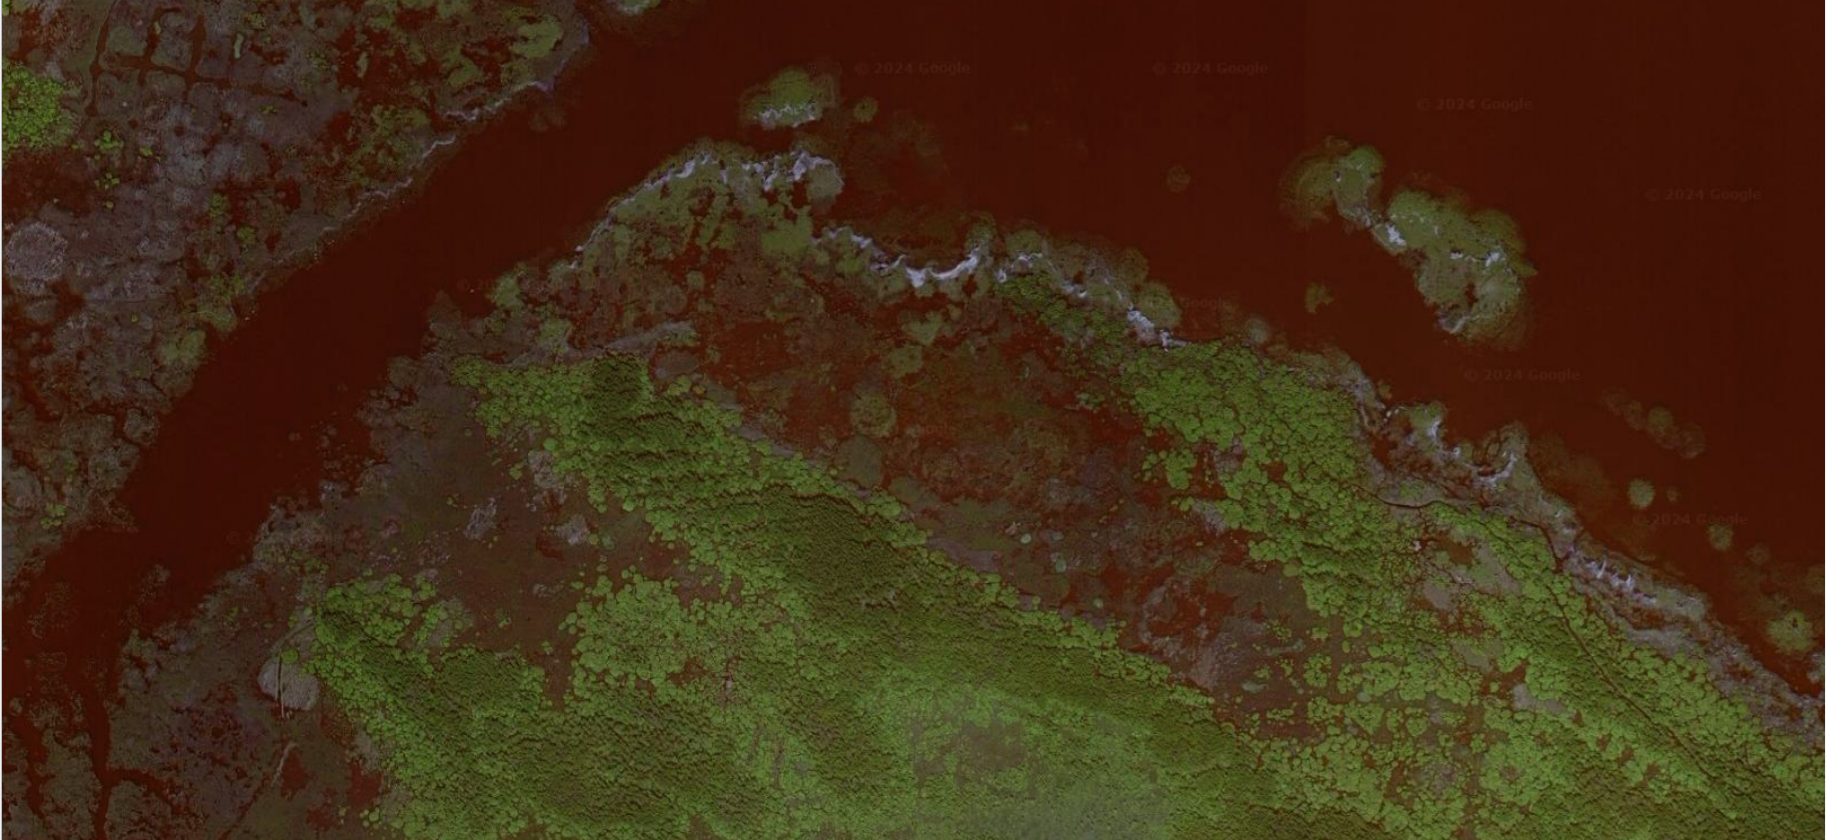

In [9]:
img = cv.imread(custom_dataset[0])
Image.fromarray(img)

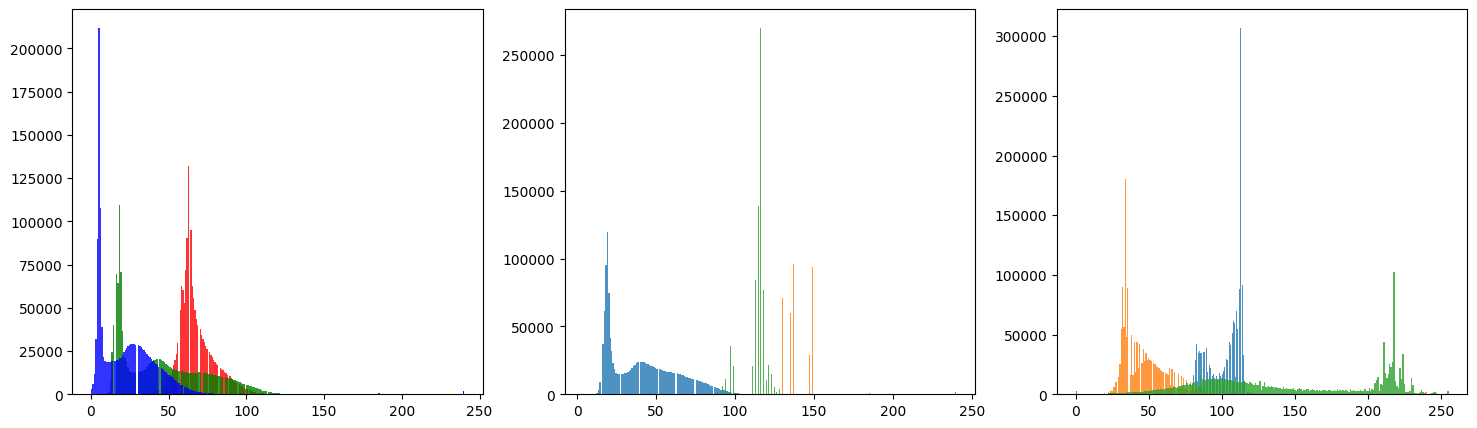

In [10]:
r, g, b = map(np.array, Image.fromarray(img).split())

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(18,5))

ax1.hist(r.ravel(), bins=256, alpha=0.8, color='red')
ax1.hist(g.ravel(), bins=256, alpha=0.8, color='green')
ax1.hist(b.ravel(), bins=256, alpha=0.8, color='blue')

y,u,v = map(np.array, Image.fromarray(cv.cvtColor(img, cv.COLOR_BGR2YUV)).split())

ax2.hist(y.ravel(), bins=256, alpha=0.8)
ax2.hist(u.ravel(), bins=256, alpha=0.8)
ax2.hist(v.ravel(), bins=256, alpha=0.8)

h, l, s = map(np.array, Image.fromarray(cv.cvtColor(img, cv.COLOR_BGR2HLS)).split())
ax3.hist(h.ravel(), bins=256, alpha=0.8)
ax3.hist(l.ravel(), bins=256, alpha=0.8)
ax3.hist(s.ravel(), bins=256, alpha=0.8)

plt.show()

In [11]:
def coords_processing(mask, coords):
    coastline_coords = []
    row, col = mask.shape

    for coord in coords:
        r, c = coord[0], coord[1]
        neighbours = []

        for j in range(r - 1, r + 2):
            for k in range(c - 1, c + 2):
                if (0 <= j < row) and (0 <= k < col) and j != r and k != c:
                    neighbours.append(int(mask[j][k]))

        if any([neigh not in [1,3,5] for neigh in neighbours]):
            coastline_coords.append((r, c))

    return coastline_coords

In [12]:
def get_coastlines(img : np.ndarray, mask : np.ndarray):
    if mask.shape.__len__() >= 3:
        raise ValueError('Expected 2-dim mask')
    row, col = mask.shape

    coastlines_coord = []
    coords = np.argwhere(mask == 5)
    np.append(coords, np.argwhere(mask == 1))
    np.append(coords, np.where(mask == 3))

    if coords.shape[0] == 0:
        return np.array([])

    PROCESS_COUNT = math.ceil(np.log2(coords.shape[0]))

    print(f'Mask shape {mask.shape} | Coordinates count : {coords.shape[0]} | Process count : {PROCESS_COUNT} |  Expected time : {coords.shape[0] * 9 / 1e6 }s')

    one_range = len(coords) // PROCESS_COUNT
    ranges = [(one_range * i, one_range * (i + 1)) for i in range(PROCESS_COUNT - 1)]
    ranges += [(ranges[-1][1], len(coords))]

    values = Parallel(n_jobs=PROCESS_COUNT)(delayed(coords_processing)(mask, coords[r[0] : r[1]]) for r in ranges)        
    for val in values:
        coastlines_coord.extend(val)

    return np.array(coastlines_coord)

In [30]:
img = cv.imread(floodnet_dataset_img[150])
mask = cv.imread(floodnet_dataset_label[150])
mask = mask[: , :, 0]

coords = get_coastlines(img, mask)
coords.shape

Mask shape (3072, 4592) | Coordinates count : 6368129 | Process count : 23 |  Expected time : 57.313161s


(10157, 2)

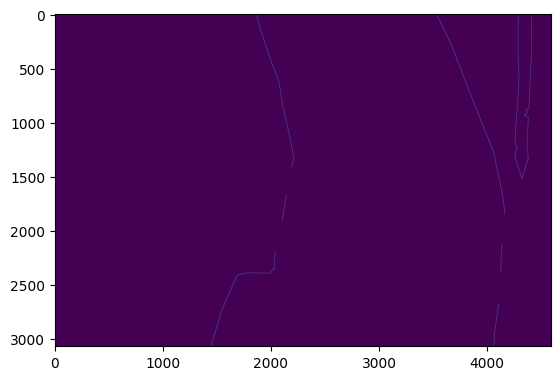

In [31]:
zeros = np.zeros((mask.shape[0], mask.shape[1]))
for coord in coords:
    zeros[coord[0]][coord[1]] = 255


plt.imshow(zeros)

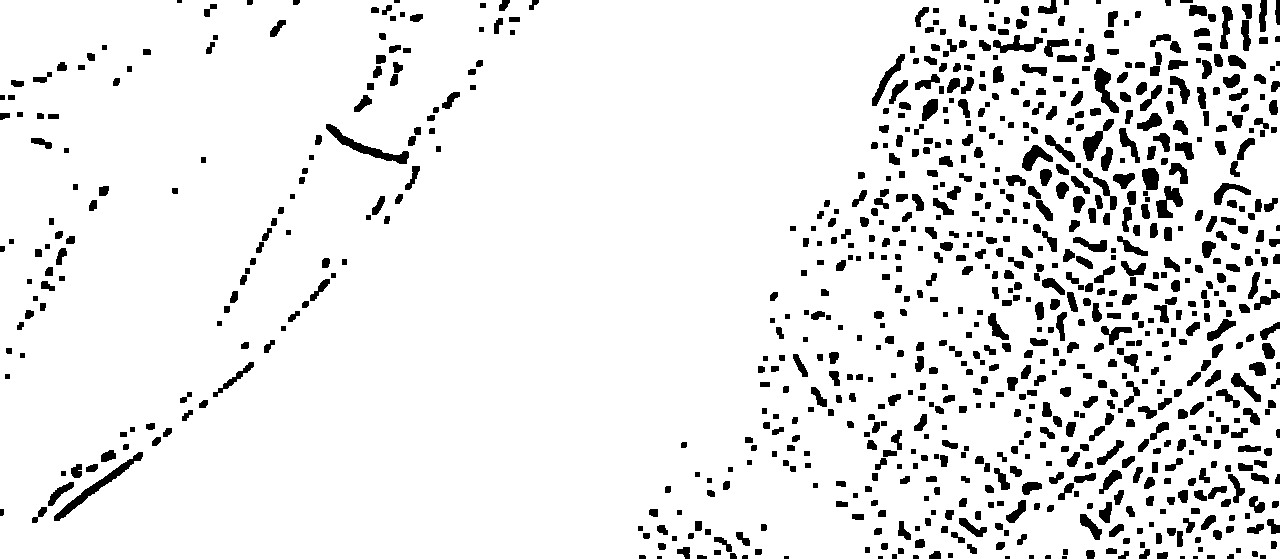

In [170]:
img = cv.imread('photo1720672999.jpeg')
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
blur = cv.GaussianBlur(gray, (11,11), sigmaX=3, sigmaY=3)

thresh = cv.adaptiveThreshold(blur, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 11, 2)
thresh = cv.GaussianBlur(thresh, (5,5), sigmaX=3, sigmaY=3)

kernel = np.ones((5,5), np.uint8)
erosion = cv.morphologyEx(src=thresh, kernel=kernel, iterations=1, op=cv.MORPH_CLOSE)

Image.fromarray(erosion)

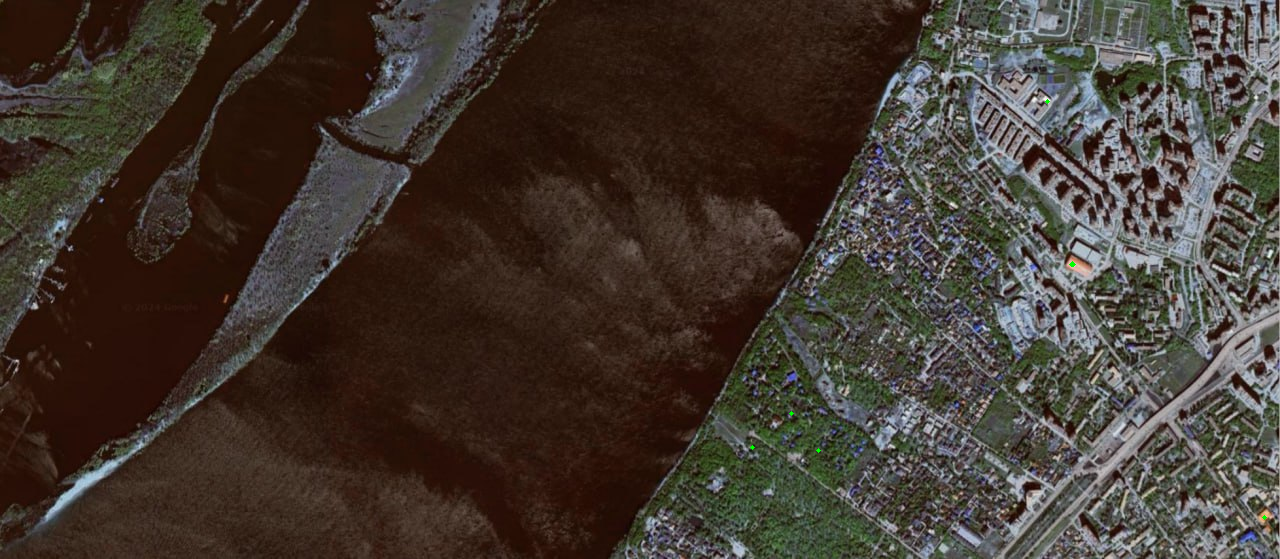

In [166]:
img = cv.imread('photo1720672999.jpeg')
mask = cv.imread('photo1720672999.jpeg')

mask = mask[:, :, 0]

#coords = get_coastlines(img, mask)


mask[mask == 5] = 255
mask[mask != 255] = 0

In [146]:
model = SAM('sam_b.pt')

result = model(img, points=[229, 640])


0: 1024x1024 19636.8ms
Speed: 65.6ms preprocess, 19636.8ms inference, 0.0ms postprocess per image at shape (1, 3, 1024, 1024)


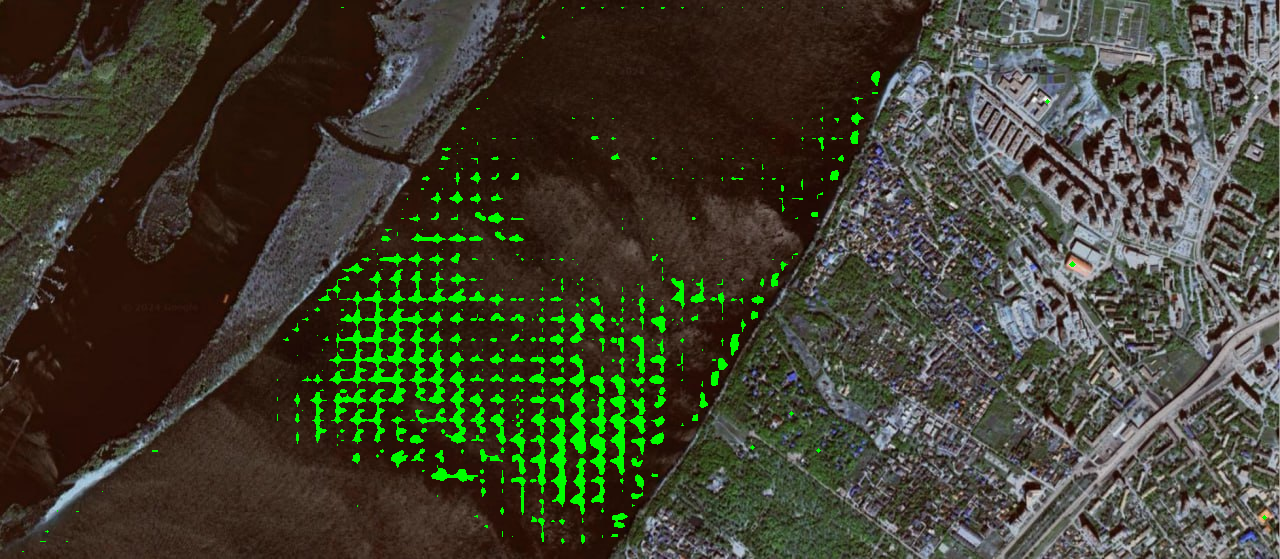

In [165]:
mask = result[0].masks.data.numpy()[0].astype(np.uint8)
img[mask == 1] = [0,255,0]
Image.fromarray(img)